# Guss

## Header Files

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import warnings
import threading
import time

In [2]:
# Suppress DeprecationWarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
color_pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

## Read the File

In [4]:
guss = pd.read_csv('guss.csv')

## Evaluate Total Power

In [5]:
phases = [1, 2, 3, 'NPE']
P1 = np.zeros(len(guss))
P2 = np.zeros(len(guss))
P3 = np.zeros(len(guss))
Pn = np.zeros(len(guss))

P = [P1, P2, P3, Pn]

for phase in range(len(phases)):
    for i in range(3, 50, 2):
        P[phase] += (guss[f"har{i:02}V{phases[phase]}_Avg [V]"] * guss[f"har{i:02}I{phases[phase]}_Avg [A]"])

<Axes: >

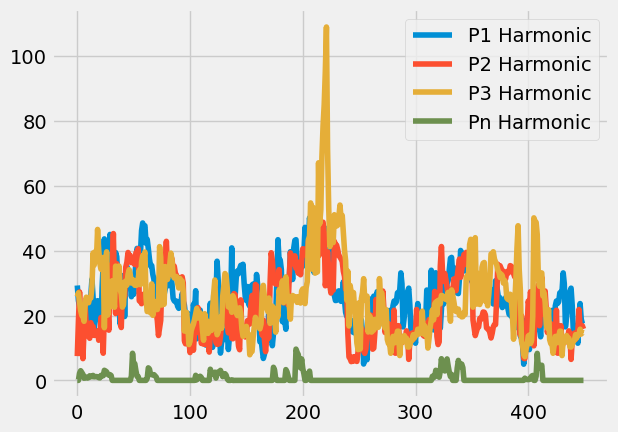

In [7]:
g_pwr = pd.DataFrame({'Datetime':guss['Time'], 'P1 Harmonic':P1, 'P2 Harmonic':P2, 'P3 Harmonic':P3, 'Pn Harmonic':Pn})
g_pwr.plot()

In [8]:
g_pwr.head(3)

,Datetime,P1 Harmonic,P2 Harmonic,P3 Harmonic,Pn Harmonic
0,8/14/2023 1:43:00 PM,29.265376,7.479787,25.777348,0.000000
1,8/14/2023 1:53:00 PM,24.584494,18.285024,27.008988,0.000000
2,8/14/2023 2:03:00 PM,22.834406,27.270414,24.162201,2.202178


## Normalize data on P3

The graph above reveals a spike on P3 which is clearly an error, so we will remove it.

<Axes: >

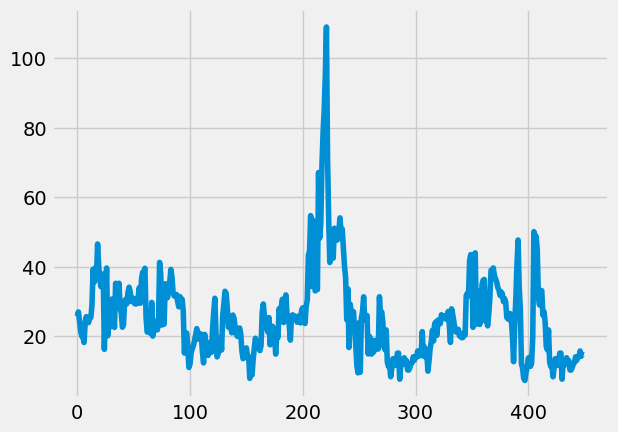

In [9]:
g_p3_harmonic = g_pwr['P3 Harmonic']
g_p3_harmonic.plot()

In [10]:
g_p3_mean = np.mean(g_p3_harmonic)
g_p3_std = np.std(g_p3_harmonic)
print(f'Mean of P3: {g_p3_mean}\nStandard Deviation of P3: {g_p3_std}')

Mean of P3: 25.435644346666667
Standard Deviation of P3: 12.407723855243086


In [11]:
# Define threshold (2 or 3 standard deviations)
threshold = 2
outliers = np.abs(g_p3_harmonic - g_p3_mean) > threshold*g_p3_std

In [12]:
g_p3_harmonic

0      25.777348
1      27.008988
2      24.162201
3      21.499425
4      20.011341
         ...    
445    14.047336
446    15.781676
447    14.285993
448    14.803185
449    14.640801
Name: P3 Harmonic, Length: 450, dtype: float64

/tmp/ipykernel_22674/104797706.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_p3_harmonic[outliers] = g_pwr['P3 Harmonic'].rolling(3).mean()
/tmp/ipykernel_22674/104797706.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_p3_harmonic[outliers] = g_pwr['P3 Harmonic'].rolling(3).mean()
/tmp/ipykernel_22674/104797706.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g_p3_harmonic[outliers] = g_pwr['P3 Harmonic'].rolling(3).me

<Axes: >

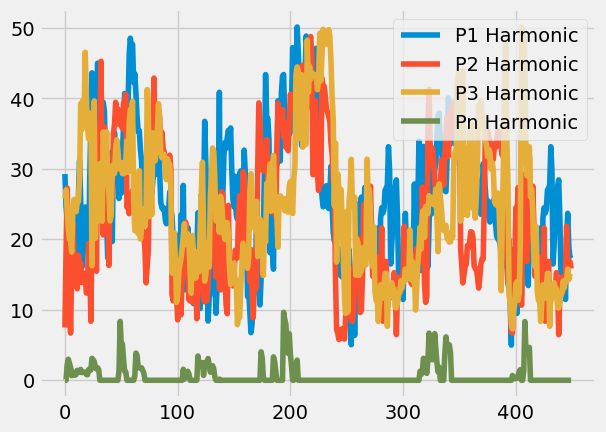

In [15]:
#g_p3_harmonic[outliers] = np.median(g_p3_harmonic)
for _ in range(20):
    g_p3_harmonic[outliers] = g_pwr['P3 Harmonic'].rolling(3).mean()

g_pwr.plot()

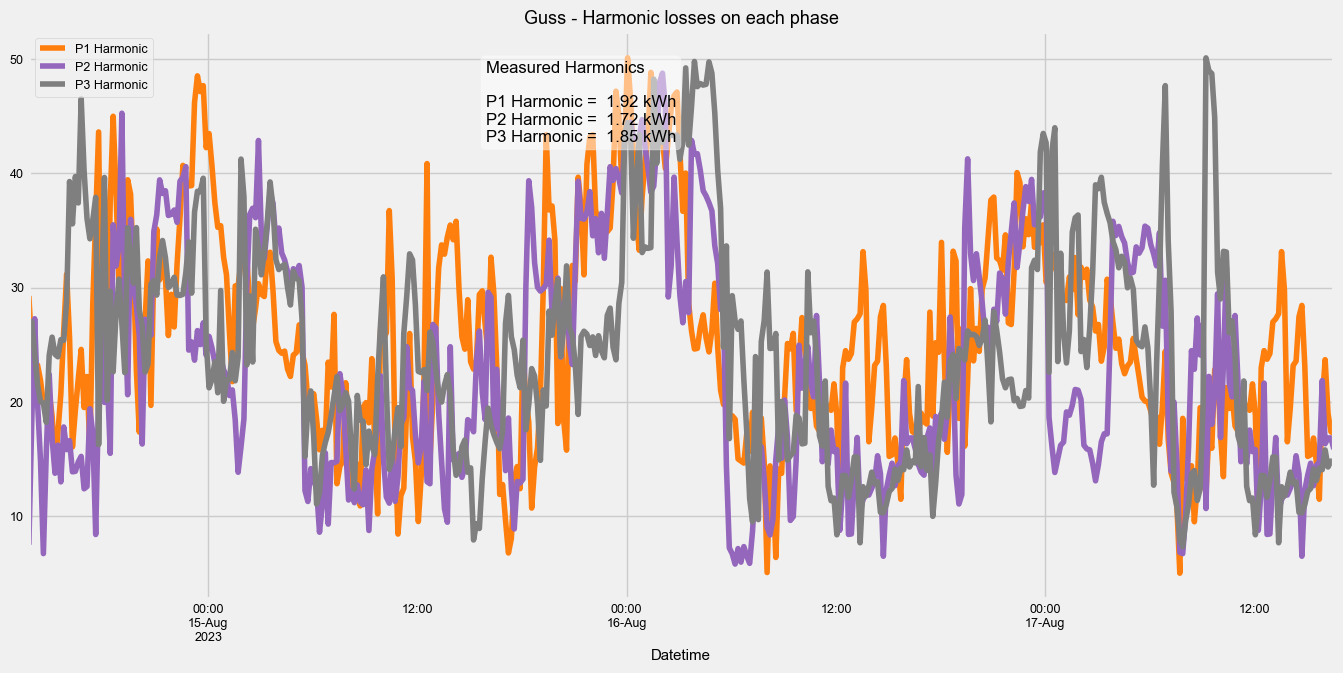

In [21]:
fig, axe = plt.subplots(figsize=(15, 7))

g_pwr_ = g_pwr.set_index('Datetime')
g_pwr_.index = pd.to_datetime(g_pwr_.index, format="%m/%d/%Y %I:%M:%S %p")

g_pwr_['P1 Harmonic'].plot(ax=axe, color=color_pal[1], title='Guss - Harmonic losses on each phase', legend='P1 Harmonic')
g_pwr_['P2 Harmonic'].plot(ax=axe, color=color_pal[4], legend='P2 Harmonic')
g_pwr_['P3 Harmonic'].plot(ax=axe, color=color_pal[7], legend='P3 Harmonic')

# Set the font style
font_style = {'family': 'arial', 'weight': 'normal', 'size': 9
              #, 'color':'darkred'
             }

# Apply the font style
plt.rc('font', **font_style)

axe.legend(['P1 Harmonic', 'P2 Harmonic', 'P3 Harmonic'])
# Add text annotation at a specific point
axe.text(0.35, 0.95, 
         f'Measured Harmonics\n\nP1 Harmonic = {g_pwr['P1 Harmonic'].sum()/6000:>5.2f} kWh\nP2 Harmonic = {g_pwr['P2 Harmonic'].sum()/6000:>5.2f} kWh\nP3 Harmonic = {g_pwr['P3 Harmonic'].sum()/6000:>5.2f} kWh', transform=axe.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.savefig('gus_harmonics_on_each_phase.jpg')
plt.show()

## Separating the Harmonic Power on each phase

In [26]:
g_p1 = pd.DataFrame({'Datetime':g_pwr['Datetime'], 'P1_Harmonic':g_pwr['P1 Harmonic']})
g_p2 = pd.DataFrame({'Datetime':g_pwr['Datetime'], 'P2_Harmonic':g_pwr['P2 Harmonic']})
g_p3 = pd.DataFrame({'Datetime':g_pwr['Datetime'], 'P3_Harmonic':g_pwr['P3 Harmonic']})
g_pn = pd.DataFrame({'Datetime':g_pwr['Datetime'], 'Pn_Harmonic':g_pwr['Pn Harmonic']})

In [27]:
g_p1 = g_p1.set_index('Datetime')
g_p1.index = pd.to_datetime(g_p1.index, format="%m/%d/%Y %I:%M:%S %p")

g_p2 = g_p2.set_index('Datetime')
g_p2.index = pd.to_datetime(g_p2.index, format="%m/%d/%Y %I:%M:%S %p")

g_p3 = g_p3.set_index('Datetime')
g_p3.index = pd.to_datetime(g_p3.index, format="%m/%d/%Y %I:%M:%S %p")

g_pn = g_pn.set_index('Datetime')
g_pn.index = pd.to_datetime(g_pn.index, format="%m/%d/%Y %I:%M:%S %p")

## Feature Creation

In [28]:
def create_features(df):
    """
    Creates time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute
    
    return df

In [29]:
g_p1 = create_features(g_p1)   
g_p2 = create_features(g_p2)   
g_p3 = create_features(g_p3)
g_pn = create_features(g_pn)

g_p2.head()

,P2_Harmonic,hour,minute
Datetime,,,
2023-08-14 13:43:00,7.479787,13,43
2023-08-14 13:53:00,18.285024,13,53
2023-08-14 14:03:00,27.270414,14,3
2023-08-14 14:13:00,19.874471,14,13
2023-08-14 14:23:00,14.863560,14,23


## Boxplot of Feature Importance

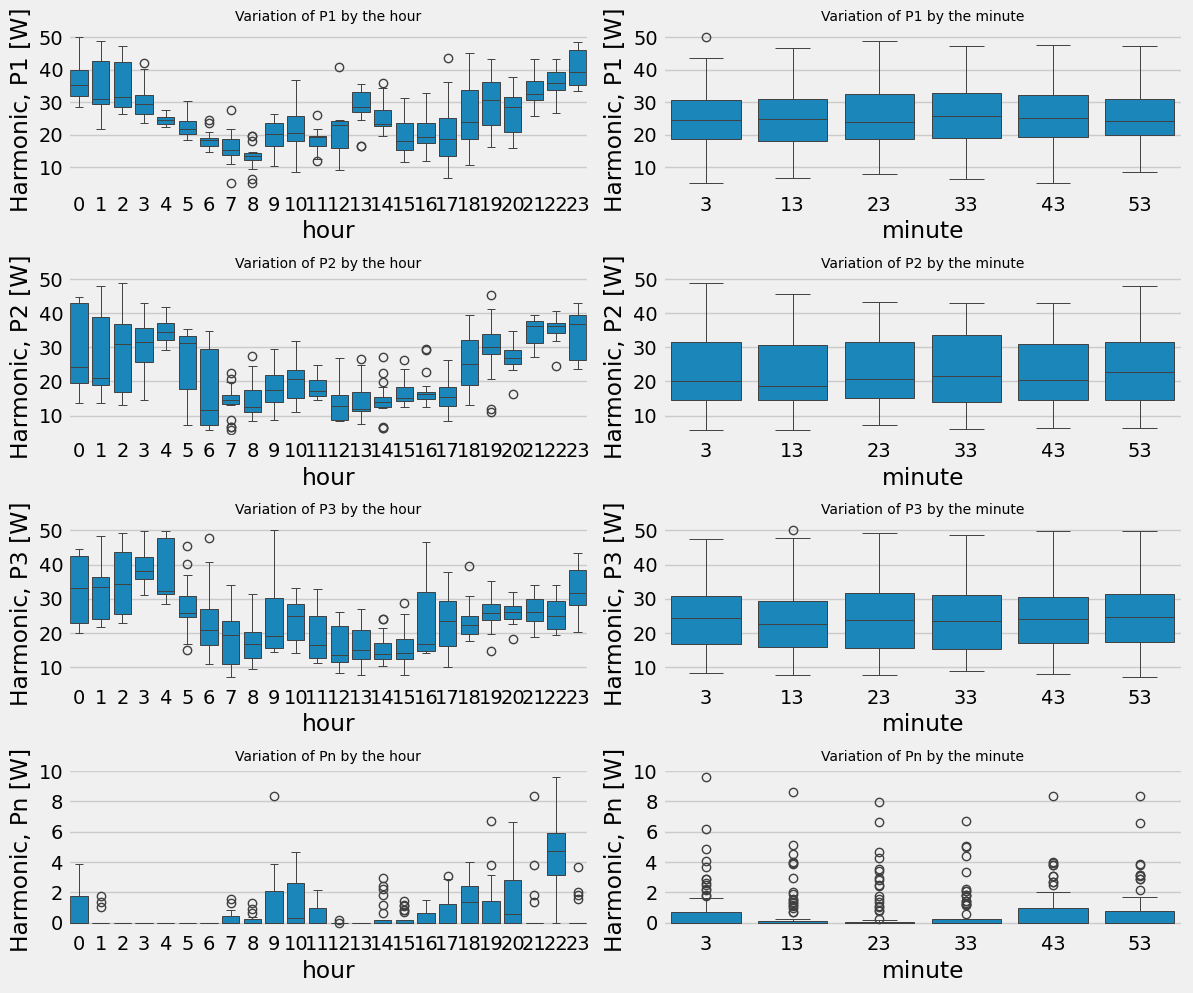

In [30]:
g_ps = [g_p1, g_p2, g_p3, g_pn]
ps = [1, 2, 3, 'n']
_2nd_iter = ['hour', 'minute']

# Create subplots
fig, axes = plt.subplots(nrows=len(g_ps), ncols=2, figsize=(12, 10))

axes = axes.flatten()

# Set the font style
font_style = {'family': 'arial', 'weight': 'normal', 'size': 9
              #, 'color':'darkred'
             }

# Apply the font style
plt.rc('font', **font_style)

i = 0
for ctr in range(len(g_ps)):
    for b in range(2):
        sns.boxplot(x=_2nd_iter[b], y=f'P{ps[ctr]}_Harmonic', data=g_ps[ctr], ax=axes[i], linewidth=0.7)
        axes[i].set_title(f'Variation of P{ps[ctr]} by the {_2nd_iter[b]}', fontsize=10)
        axes[i].set_ylabel(f'Harmonic, P{ps[ctr]} [W]')
        i += 1

# Adjust layout
plt.tight_layout()

plt.savefig('guss_variations_by_features.jpg')

# Show the plot
plt.show()

## Model Creation

In [31]:
def mape(y_true, y_pred):
    """mape: mean_absolute_percentage_error"""
    return np.mean(np.abs((y_true - y_pred)/y_true))*100

### Phase 1 (P1)

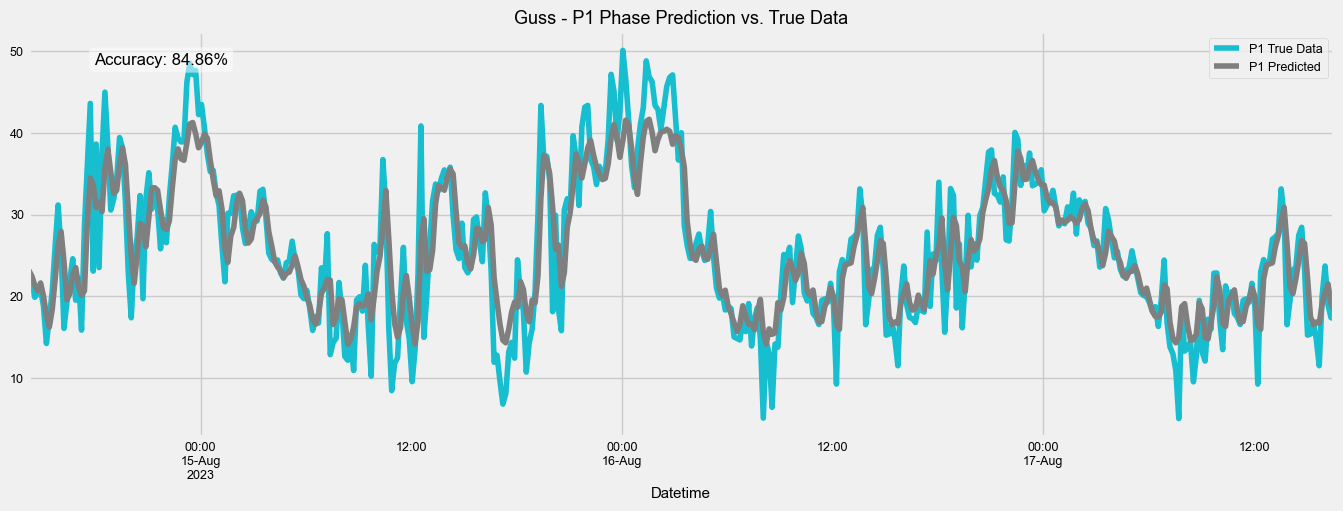

In [32]:
# Create a deep copy
g_p1_ = g_p1.copy(deep=True)

# Create lags
g_p1_['lag_1'] = g_p1_['P1_Harmonic'].shift(1)
g_p1_['lag_2'] = g_p1_['P1_Harmonic'].shift(2)
g_p1_['lag_3'] = g_p1_['P1_Harmonic'].shift(3)

# Create rolling window features
g_p1_['rolling_mean_3'] = g_p1_['P1_Harmonic'].rolling(window=3).mean()
g_p1_['rolling_std_3'] = g_p1_['P1_Harmonic'].rolling(window=3).std()

# Dropna
g_p1_.dropna(inplace=True)

# Feature creation and extraction.
X = g_p1_.drop(columns=['P1_Harmonic'])
y = g_p1_['P1_Harmonic']

# Train the SVR Model
g_p1_SVR = SVR(kernel='rbf', C=1.3, epsilon=0.3)
g_p1_SVR.fit(X, y)

# Make predictions
g_p1_['Predictions'] = g_p1_SVR.predict(X)

# Evaluate Accuracy
p1_accuracy = 100 - mape(g_p1_['P1_Harmonic'], g_p1_['Predictions'])

# Make plots.
ax = g_p1_[['P1_Harmonic']].plot(figsize=(15,5), color=color_pal[-1], title="Guss - P1 Phase Prediction vs. True Data")
g_p1_['Predictions'].plot(ax=ax, style='-', color=color_pal[-3])

accur = f'{p1_accuracy:.2f}%'
ax.set_xlabel('Datetime', rotation=0)
ax.legend(['P1 True Data', 'P1 Predicted'])

# Add text annotation at a specific point
ax.text(0.05, 0.95, f'Accuracy: {accur}', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.savefig('gus_p1__true_vs_predicted.jpg')
plt.show()

In [48]:
g_p1_.head(3)

,P1_Harmonic,hour,minute,lag_1,lag_2,lag_3,rolling_mean_3,rolling_std_3,Predictions
Datetime,,,,,,,,,
2023-08-14 14:13:00,23.210057,14,13,22.834406,24.584494,29.265376,23.542986,0.921321,23.125673
2023-08-14 14:23:00,21.889767,14,23,23.210057,22.834406,24.584494,22.644743,0.680272,22.479079
2023-08-14 14:33:00,19.853264,14,33,21.889767,23.210057,22.834406,21.651029,1.691083,21.351380


<br><br><br>

### Phase 2 (P2)

In [26]:
color_pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

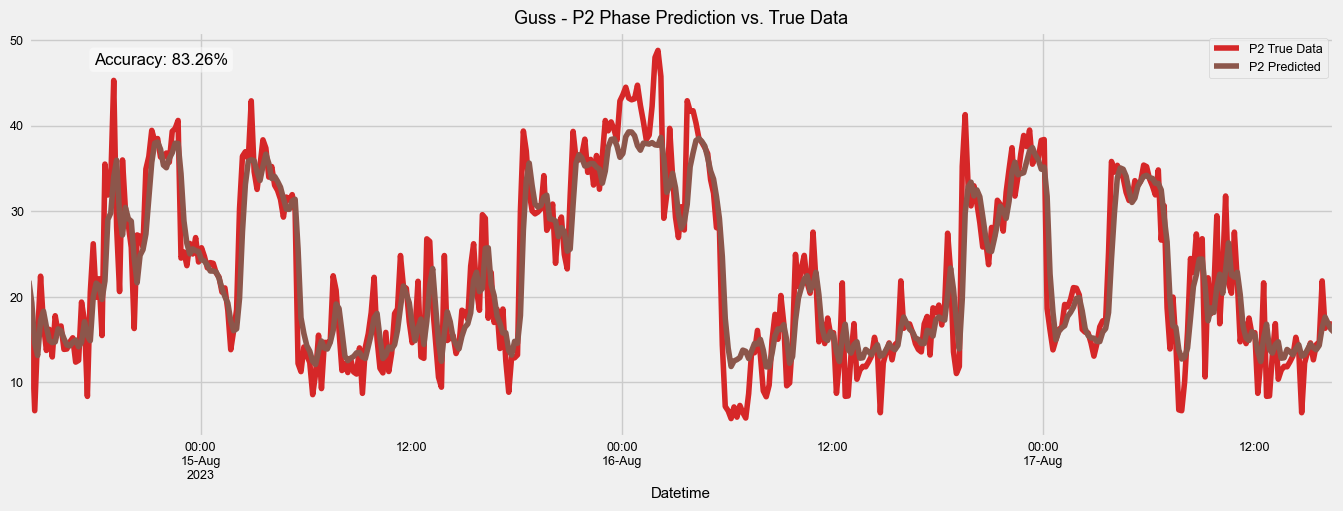

In [33]:
# Create a deep copy
g_p2_ = g_p2.copy(deep=True)

# Create lags
g_p2_['lag_1'] = g_p2_['P2_Harmonic'].shift(1)
g_p2_['lag_2'] = g_p2_['P2_Harmonic'].shift(2)
g_p2_['lag_3'] = g_p2_['P2_Harmonic'].shift(3)

# Create rolling window features
g_p2_['rolling_mean_3'] = g_p2_['P2_Harmonic'].rolling(window=3).mean()
g_p2_['rolling_std_3'] = g_p2_['P2_Harmonic'].rolling(window=3).std()

# Dropna
g_p2_.dropna(inplace=True)

# Feature creation and extraction.
X = g_p2_.drop(columns=['P2_Harmonic'])
y = g_p2_['P2_Harmonic']

# Train the SVR Model
g_p2_SVR = SVR(kernel='rbf', C=1.3, epsilon=0.3)
g_p2_SVR.fit(X, y)

# Make predictions
g_p2_['Predictions'] = g_p2_SVR.predict(X)

# Evaluate Accuracy
p2_accuracy = 100 - mape(g_p2_['P2_Harmonic'], g_p2_['Predictions'])

# Make plots.
ax = g_p2_[['P2_Harmonic']].plot(figsize=(15,5), color=color_pal[3], title="Guss - P2 Phase Prediction vs. True Data")
g_p2_['Predictions'].plot(ax=ax, style='-', color=color_pal[5])

accur = f'{p2_accuracy:.2f}%'
ax.set_xlabel('Datetime', rotation=0)
ax.legend(['P2 True Data', 'P2 Predicted'])

# Add text annotation at a specific point
ax.text(0.05, 0.95, f'Accuracy: {accur}', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.savefig('gus_p2__true_vs_predicted.jpg')
plt.show()

In [20]:
print(f'Accuracy (%): {100 - mape(g_p2_['P2_Harmonic'], g_p2_['Predictions']) : .2f}%')

Accuracy (%):  83.26%


<br><br><br>

### Phase 3 (P3)

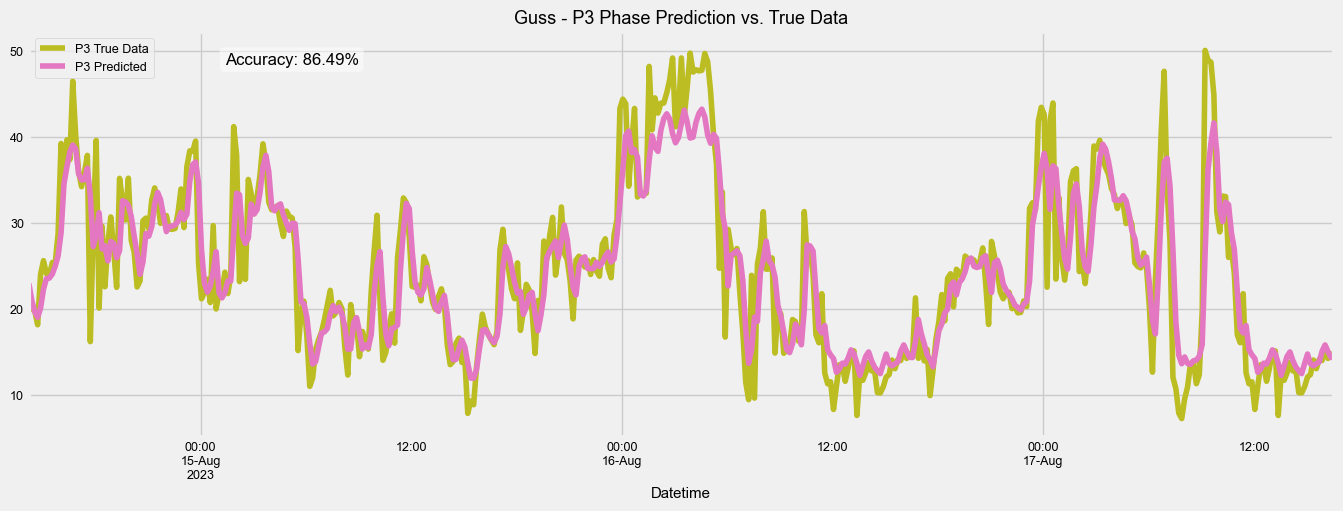

In [34]:
# Create a deep copy
g_p3_ = g_p3.copy(deep=True)

# Create lags
g_p3_['lag_1'] = g_p3_['P3_Harmonic'].shift(1)
g_p3_['lag_2'] = g_p3_['P3_Harmonic'].shift(2)
g_p3_['lag_3'] = g_p3_['P3_Harmonic'].shift(3)

# Create rolling window features
g_p3_['rolling_mean_3'] = g_p3_['P3_Harmonic'].rolling(window=3).mean()
g_p3_['rolling_std_3'] = g_p3_['P3_Harmonic'].rolling(window=3).std()

# Dropna
g_p3_.dropna(inplace=True)

# Feature creation and extraction.
X = g_p3_.drop(columns=['P3_Harmonic'])
y = g_p3_['P3_Harmonic']

# Train the SVR Model
g_p3_SVR = SVR(kernel='rbf', C=1.3, epsilon=0.3)
g_p3_SVR.fit(X, y)

# Make predictions
g_p3_['Predictions'] = g_p3_SVR.predict(X)

# Evaluate Accuracy
p3_accuracy = 100 - mape(g_p3_['P3_Harmonic'], g_p3_['Predictions'])

# Make plots.
ax = g_p3_[['P3_Harmonic']].plot(figsize=(15,5), color=color_pal[-2], title="Guss - P3 Phase Prediction vs. True Data")
g_p3_['Predictions'].plot(ax=ax, style='-', color=color_pal[-4])

accur = f'{p3_accuracy:.2f}%'
ax.set_xlabel('Datetime', rotation=0)
ax.legend(['P3 True Data', 'P3 Predicted'])

# Add text annotation at a specific point
ax.text(0.15, 0.95, f'Accuracy: {accur}', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

plt.savefig('gus_p3__true_vs_predicted.jpg')
plt.show()

<br><br><br><br>

## Prediction on Future and Unseen Data

### Phase 1 (P1)

In [35]:
# The Seed
g_p1_seed = g_p1_.tail(10).copy(deep=True)
g_p1_seed

,P1_Harmonic,hour,minute,lag_1,lag_2,lag_3,rolling_mean_3,rolling_std_3,Predictions
Datetime,,,,,,,,,
2023-08-17 15:03:00,15.214596,15,3,23.175876,28.438135,27.454050,22.276202,6.657519,22.262075
2023-08-17 15:13:00,15.352021,15,13,15.214596,23.175876,28.438135,17.914164,4.557294,17.493623
2023-08-17 15:23:00,16.824530,15,23,15.352021,15.214596,23.175876,15.797049,0.892474,16.524161
2023-08-17 15:33:00,14.674273,15,33,16.824530,15.352021,15.214596,15.616941,1.099335,16.827503
2023-08-17 15:43:00,11.461249,15,43,14.674273,16.824530,15.352021,14.320017,2.699133,16.643411
2023-08-17 15:53:00,20.059938,15,53,11.461249,14.674273,16.824530,15.398487,4.344851,19.028851
2023-08-17 16:03:00,23.686272,16,3,20.059938,11.461249,14.674273,18.402486,6.278786,20.431417
2023-08-17 16:13:00,18.963393,16,13,23.686272,20.059938,11.461249,20.903201,2.471784,21.494972
2023-08-17 16:23:00,17.371262,16,23,18.963393,23.686272,20.059938,20.006976,3.284302,19.178967


In [36]:
# number of years to predict for.
gp1_n = 5

gp1_start_date = datetime.strptime(str(list(g_p1_seed.index)[0]), '%Y-%m-%d %H:%M:%S')
gp1_end_date = gp1_start_date + relativedelta(years=gp1_n)

gp1_dates = np.array(g_p1_seed.index.astype(str))
gp1_harmonics = np.array(g_p1_seed['P1_Harmonic'].values)
gp1_hr = np.array(g_p1_seed['hour'].values)
gp1_min = np.array(g_p1_seed['minute'].values)
gp1_lag_1 = np.array(g_p1_seed['lag_1'].values)
gp1_lag_2 = np.array(g_p1_seed['lag_2'].values)
gp1_lag_3 = np.array(g_p1_seed['lag_3'].values)
gp1_roll_mean_3 = np.array(g_p1_seed['rolling_mean_3'].values)
gp1_roll_std_3 = np.array(g_p1_seed['rolling_std_3'].values)
gp1_y_pred = np.array(g_p1_seed['Predictions'].values)

# Pre-allocate memory for future values
gp1_prediction_horizon = int((gp1_end_date - gp1_start_date).total_seconds() // 600)  # 10-minute increments
gp1_future_dates = np.empty(gp1_prediction_horizon, dtype="U19")  # Pre-allocate date array (string format)
gp1_future_p1_h = np.empty(gp1_prediction_horizon)
gp1_future_lag_1 = np.empty(gp1_prediction_horizon)
gp1_future_lag_2 = np.empty(gp1_prediction_horizon)
gp1_future_lag_3 = np.empty(gp1_prediction_horizon)
gp1_future_roll_mean_3 = np.empty(gp1_prediction_horizon)
gp1_future_roll_std_3 = np.empty(gp1_prediction_horizon)
gp1_future_hr = np.empty(gp1_prediction_horizon, dtype=int)
gp1_future_min = np.empty(gp1_prediction_horizon, dtype=int)
gp1_future_y_pred = np.empty(gp1_prediction_horizon)

# Initialize current time from the last date
gp1_current_date = datetime.strptime(gp1_dates[-1], '%Y-%m-%d %H:%M:%S')

i = 0

In [37]:
def gp1_timer():
    start_time = time.time()
    while not task1_done:
        elapsed_time = time.time() - start_time
        hours, rem = divmod(elapsed_time, 3600)
        minutes, seconds = divmod(rem, 60)
        print(f"\033[1;95mElapsed time: {int(hours):02}:{int(minutes):02}:{int(seconds):02} (Run {i:,} out of {gp1_prediction_horizon:,})", end='\r')
        time.sleep(0.0001)  # Update every second

In [38]:
task1_done = False

timer1_thread = threading.Thread(target=gp1_timer)
timer1_thread.start()

# Loop to generate predictions
while i < gp1_prediction_horizon:
    # Advance time by 10 minutes
    gp1_current_date += timedelta(minutes=10)
    gp1_current_hr = gp1_current_date.hour
    gp1_current_min = gp1_current_date.minute
    
    # Append new values to the arrays
    gp1_future_dates[i] = gp1_current_date.strftime('%Y-%m-%d %H:%M:%S')
    gp1_future_hr[i] = gp1_current_hr
    gp1_future_min[i] = gp1_current_min
    gp1_future_p1_h[i] = gp1_y_pred[-1]  # Previous prediction becomes the new harmonic value
    
    # Update lag features
    gp1_future_lag_1[i] = gp1_future_p1_h[i - 1] if i > 0 else gp1_harmonics[-1]
    gp1_future_lag_2[i] = gp1_future_lag_1[i - 1] if i > 1 else gp1_lag_1[-1]
    gp1_future_lag_3[i] = gp1_future_lag_2[i - 1] if i > 2 else gp1_lag_2[-1]
    
    # Compute rolling statistics (using pre-existing values)
    gp1_window_p1_h = np.concatenate((gp1_harmonics[-2:], gp1_future_p1_h[:i+1]))[-3:]
    gp1_future_roll_mean_3[i] = np.mean(gp1_window_p1_h)
    gp1_future_roll_std_3[i] = np.std(gp1_window_p1_h)
    
    # Construct the input data for the model prediction
    gp1_X = pd.DataFrame({
        'hour': np.concatenate((gp1_hr, gp1_future_hr[:i+1])),
        'minute': np.concatenate((gp1_min, gp1_future_min[:i+1])),
        'lag_1': np.concatenate((gp1_lag_1, gp1_future_lag_1[:i+1])),
        'lag_2': np.concatenate((gp1_lag_2, gp1_future_lag_2[:i+1])),
        'lag_3': np.concatenate((gp1_lag_3, gp1_future_lag_3[:i+1])),
        'rolling_mean_3': np.concatenate((gp1_roll_mean_3, gp1_future_roll_mean_3[:i+1])),
        'rolling_std_3': np.concatenate((gp1_roll_std_3, gp1_future_roll_std_3[:i+1]))
    })
    
    # Predict and append the result
    y_pred1 = g_p1_SVR.predict(gp1_X.iloc[-1:])
    gp1_future_y_pred[i] = y_pred1

    # Update _y_pred for future iterations
    gp1_y_pred = np.append(gp1_y_pred, y_pred1)

    i += 1

task1_done = True
timer1_thread.join()
i

263088

In [39]:
g_p1_future = pd.DataFrame({'Datetime':gp1_future_dates,
                       'P1_Harmonic':gp1_future_p1_h,
                       'hour':gp1_future_hr,
                       'minute':gp1_future_min,
                       'lag_1':gp1_future_lag_1,
                       'lag_2':gp1_future_lag_2,
                       'lag_3':gp1_future_lag_3,
                       'rolling_mean_3':gp1_future_roll_mean_3,
                       'rolling_std_3':gp1_future_roll_std_3,
                       'y_pred':gp1_future_y_pred
                      })

In [40]:
g_p1_future = g_p1_future.set_index('Datetime')
g_p1_future.index = pd.to_datetime(g_p1_future.index, format='%Y-%m-%d %H:%M:%S')
g_p1_future

,P1_Harmonic,hour,minute,lag_1,lag_2,lag_3,rolling_mean_3,rolling_std_3,y_pred
Datetime,,,,,,,,,
2023-08-17 16:43:00,18.281677,16,43,17.221823,17.371262,18.963393,17.624921,0.468387,18.834064
2023-08-17 16:53:00,18.834064,16,53,18.281677,17.371262,18.963393,18.112521,0.668974,20.552253
2023-08-17 17:03:00,20.552253,17,3,18.834064,18.281677,18.963393,19.222664,0.966829,19.548495
2023-08-17 17:13:00,19.548495,17,13,20.552253,18.834064,18.281677,19.644937,0.704755,19.740158
2023-08-17 17:23:00,19.740158,17,23,19.548495,20.552253,18.834064,19.946969,0.435094,19.699512
...,...,...,...,...,...,...,...,...,...
2028-08-17 15:53:00,20.096396,15,53,19.622911,19.440072,19.671523,19.719793,0.276562,21.257690
2028-08-17 16:03:00,21.257690,16,3,20.096396,19.622911,19.440072,20.325666,0.686804,20.229961
2028-08-17 16:13:00,20.229961,16,13,21.257690,20.096396,19.622911,20.528016,0.518831,20.304077


In [41]:
g_p1_future_kWh = g_p1_future['y_pred'].sum()/6000
g_p1_future_kWh

1044.824422846025

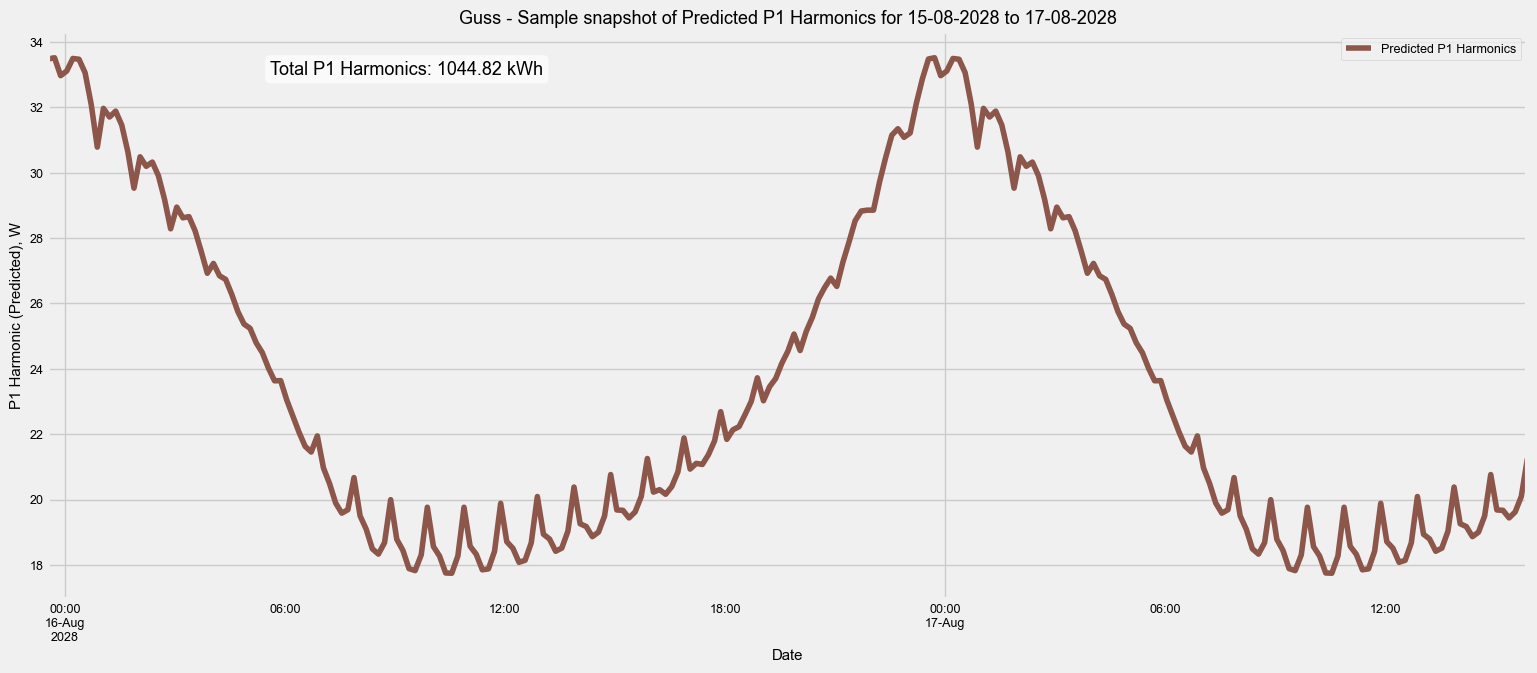

In [43]:
gp1_day = g_p1_future.loc['2028-08-15 23:33:00':'2028-08-17 15:53:00']

ax = gp1_day[['y_pred']].plot(
    figsize=(17,7), 
    label='Predicted P1 Harmonics', 
    color=color_pal[5], 
    title="Guss - Sample snapshot of Predicted P1 Harmonics for 15-08-2028 to 17-08-2028"
)

ax.set_xlabel('Datetime', rotation=0)

# Add text annotation at a specific point
ax.text(0.15, 0.95, f'Total P1 Harmonics: {g_p1_future_kWh:0.2f} kWh', transform=ax.transAxes, fontsize=13,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.73))

plt.xlabel('Date')
plt.ylabel('P1 Harmonic (Predicted), W')
plt.grid(True)
plt.legend(['Predicted P1 Harmonics'])

plt.savefig('gus_p1_predicted.jpg', dpi=307)
plt.show()

<br><br>

### Phase 2 (P2)

In [44]:
# The Seed
g_p2_seed = g_p2_.tail(10).copy(deep=True)
g_p2_seed

,P2_Harmonic,hour,minute,lag_1,lag_2,lag_3,rolling_mean_3,rolling_std_3,Predictions
Datetime,,,,,,,,,
2023-08-17 15:03:00,13.567613,15,3,12.260113,6.469383,13.693187,10.765703,3.777719,13.867711
2023-08-17 15:13:00,14.614596,15,13,13.567613,12.260113,6.469383,13.480774,1.179641,14.491660
2023-08-17 15:23:00,12.645037,15,23,14.614596,13.567613,12.260113,13.609082,0.985434,14.051890
2023-08-17 15:33:00,14.417809,15,33,12.645037,14.614596,13.567613,13.892481,1.084789,13.822022
2023-08-17 15:43:00,14.739847,15,43,14.417809,12.645037,14.614596,13.934231,1.128026,14.330307
2023-08-17 15:53:00,21.856156,15,53,14.739847,14.417809,12.645037,17.004604,4.204652,16.412506
2023-08-17 16:03:00,16.326205,16,3,21.856156,14.739847,14.417809,17.640736,3.735834,17.637372
2023-08-17 16:13:00,16.826638,16,13,16.326205,21.856156,14.739847,18.336333,3.058508,16.911434
2023-08-17 16:23:00,16.832488,16,23,16.826638,16.326205,21.856156,16.661777,0.290629,16.213080


In [45]:
# number of years to predict for.
gp2_n = 5

gp2_start_date = datetime.strptime(str(list(g_p2_seed.index)[0]), '%Y-%m-%d %H:%M:%S')
gp2_end_date = gp2_start_date + relativedelta(years=gp2_n)

gp2_dates = np.array(g_p2_seed.index.astype(str))
gp2_harmonics = np.array(g_p2_seed['P2_Harmonic'].values)
gp2_hr = np.array(g_p2_seed['hour'].values)
gp2_min = np.array(g_p2_seed['minute'].values)
gp2_lag_1 = np.array(g_p2_seed['lag_1'].values)
gp2_lag_2 = np.array(g_p2_seed['lag_2'].values)
gp2_lag_3 = np.array(g_p2_seed['lag_3'].values)
gp2_roll_mean_3 = np.array(g_p2_seed['rolling_mean_3'].values)
gp2_roll_std_3 = np.array(g_p2_seed['rolling_std_3'].values)
gp2_y_pred = np.array(g_p2_seed['Predictions'].values)

# Pre-allocate memory for future values
gp2_prediction_horizon = int((gp2_end_date - gp2_start_date).total_seconds() // 600)  # 10-minute increments
gp2_future_dates = np.empty(gp2_prediction_horizon, dtype="U19")  # Pre-allocate date array (string format)
gp2_future_p2_h = np.empty(gp2_prediction_horizon)
gp2_future_lag_1 = np.empty(gp2_prediction_horizon)
gp2_future_lag_2 = np.empty(gp2_prediction_horizon)
gp2_future_lag_3 = np.empty(gp2_prediction_horizon)
gp2_future_roll_mean_3 = np.empty(gp2_prediction_horizon)
gp2_future_roll_std_3 = np.empty(gp2_prediction_horizon)
gp2_future_hr = np.empty(gp2_prediction_horizon, dtype=int)
gp2_future_min = np.empty(gp2_prediction_horizon, dtype=int)
gp2_future_y_pred = np.empty(gp2_prediction_horizon)

# Initialize current time from the last date
gp2_current_date = datetime.strptime(gp2_dates[-1], '%Y-%m-%d %H:%M:%S')

j = 0

In [46]:
def gp2_timer():
    start_time = time.time()
    while not task2_done:
        elapsed_time = time.time() - start_time
        hours, rem = divmod(elapsed_time, 3600)
        minutes, seconds = divmod(rem, 60)
        print(f"\033[1;95mElapsed time: {int(hours):02}:{int(minutes):02}:{int(seconds):02} (Run {j:,} out of {gp2_prediction_horizon:,})", end='\r')
        time.sleep(0.0001)  # Update every second

In [47]:
task2_done = False

timer2_thread = threading.Thread(target=gp2_timer)
timer2_thread.start()

# Loop to generate predictions
while j < gp2_prediction_horizon:
    # Advance time by 10 minutes
    gp2_current_date += timedelta(minutes=10)
    gp2_current_hr = gp2_current_date.hour
    gp2_current_min = gp2_current_date.minute
    
    # Append new values to the arrays
    gp2_future_dates[j] = gp2_current_date.strftime('%Y-%m-%d %H:%M:%S')
    gp2_future_hr[j] = gp2_current_hr
    gp2_future_min[j] = gp2_current_min
    gp2_future_p2_h[j] = gp2_y_pred[-1]  # Previous prediction becomes the new harmonic value
    
    # Update lag features
    gp2_future_lag_1[j] = gp2_future_p2_h[j - 1] if j > 0 else gp2_harmonics[-1]
    gp2_future_lag_2[j] = gp2_future_lag_1[j - 1] if j > 1 else gp2_lag_1[-1]
    gp2_future_lag_3[j] = gp2_future_lag_2[j - 1] if j > 2 else gp2_lag_2[-1]
    
    # Compute rolling statistics (using pre-existing values)
    gp2_window_p2_h = np.concatenate((gp2_harmonics[-2:], gp2_future_p2_h[:j+1]))[-3:]
    gp2_future_roll_mean_3[j] = np.mean(gp2_window_p2_h)
    gp2_future_roll_std_3[j] = np.std(gp2_window_p2_h)
    
    # Construct the input data for the model prediction
    gp2_X = pd.DataFrame({
        'hour': np.concatenate((gp2_hr, gp2_future_hr[:j+1])),
        'minute': np.concatenate((gp2_min, gp2_future_min[:j+1])),
        'lag_1': np.concatenate((gp2_lag_1, gp2_future_lag_1[:j+1])),
        'lag_2': np.concatenate((gp2_lag_2, gp2_future_lag_2[:j+1])),
        'lag_3': np.concatenate((gp2_lag_3, gp2_future_lag_3[:j+1])),
        'rolling_mean_3': np.concatenate((gp2_roll_mean_3, gp2_future_roll_mean_3[:j+1])),
        'rolling_std_3': np.concatenate((gp2_roll_std_3, gp2_future_roll_std_3[:j+1]))
    })
    
    # Predict and append the result
    y_pred2 = g_p2_SVR.predict(gp2_X.iloc[-1:])
    gp2_future_y_pred[j] = y_pred2

    # Update _y_pred for future iterations
    gp2_y_pred = np.append(gp2_y_pred, y_pred2)

    j += 1

task2_done = True
timer2_thread.join()
j

IndexError: index 263088 is out of bounds for axis 0 with size 263088

In [49]:
task2_done = True
timer2_thread.join()
j

263088

In [50]:
g_p2_future = pd.DataFrame({'Datetime':gp2_future_dates,
                       'P1_Harmonic':gp2_future_p2_h,
                       'hour':gp2_future_hr,
                       'minute':gp2_future_min,
                       'lag_1':gp2_future_lag_1,
                       'lag_2':gp2_future_lag_2,
                       'lag_3':gp2_future_lag_3,
                       'rolling_mean_3':gp2_future_roll_mean_3,
                       'rolling_std_3':gp2_future_roll_std_3,
                       'y_pred':gp2_future_y_pred
                      })

In [51]:
g_p2_future = g_p2_future.set_index('Datetime')
g_p2_future.index = pd.to_datetime(g_p2_future.index, format='%Y-%m-%d %H:%M:%S')
g_p2_future

,P1_Harmonic,hour,minute,lag_1,lag_2,lag_3,rolling_mean_3,rolling_std_3,y_pred
Datetime,,,,,,,,,
2023-08-17 16:43:00,15.890935,16,43,15.850450,16.832488,16.826638,16.191291,0.453696,15.434649
2023-08-17 16:53:00,15.434649,16,53,15.890935,16.832488,16.826638,15.725345,0.206216,15.619574
2023-08-17 17:03:00,15.619574,17,3,15.434649,15.890935,16.826638,15.648386,0.187389,15.507575
2023-08-17 17:13:00,15.507575,17,13,15.619574,15.434649,15.890935,15.520599,0.076055,15.133750
2023-08-17 17:23:00,15.133750,17,23,15.507575,15.619574,15.434649,15.420300,0.207716,15.185706
...,...,...,...,...,...,...,...,...,...
2028-08-17 15:53:00,14.201179,15,53,14.191663,14.257413,14.173263,14.216752,0.029013,14.734905
2028-08-17 16:03:00,14.734905,16,3,14.201179,14.191663,14.257413,14.375916,0.253873,14.638822
2028-08-17 16:13:00,14.638822,16,13,14.734905,14.201179,14.191663,14.524969,0.232290,14.399959


In [52]:
g_p2_future_kWh = g_p2_future['y_pred'].sum()/6000
g_p2_future_kWh

663.0629881985903

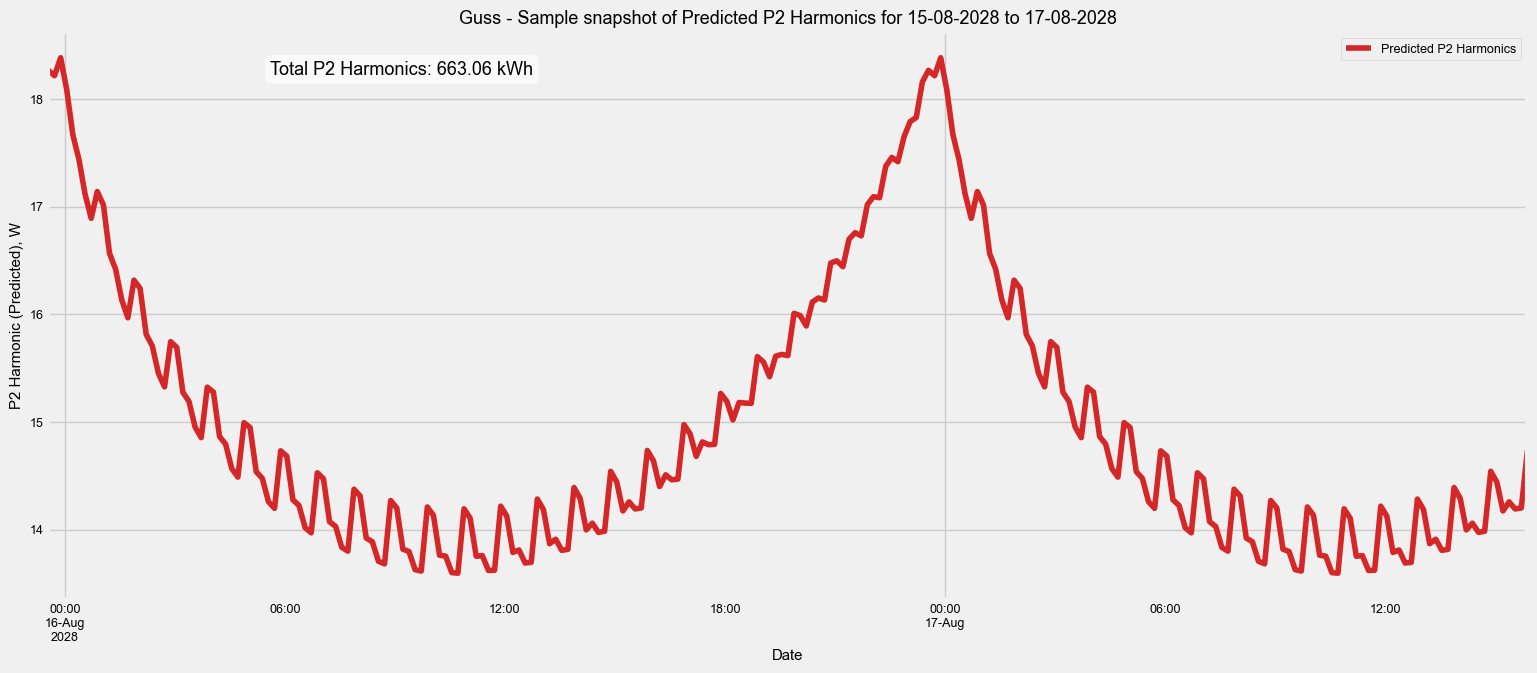

In [55]:
gp2_day = g_p2_future.loc['2028-08-15 23:33:00':'2028-08-17 15:53:00']

ax = gp2_day[['y_pred']].plot(
    figsize=(17,7), 
    label='Predicted P2 Harmonics', 
    color=color_pal[3], 
    title="Guss - Sample snapshot of Predicted P2 Harmonics for 15-08-2028 to 17-08-2028"
)

ax.set_xlabel('Datetime', rotation=0)

# Add text annotation at a specific point
ax.text(0.15, 0.95, f'Total P2 Harmonics: {g_p2_future_kWh:0.2f} kWh', transform=ax.transAxes, fontsize=13,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.73))

plt.xlabel('Date')
plt.ylabel('P2 Harmonic (Predicted), W')
plt.grid(True)
plt.legend(['Predicted P2 Harmonics'])

plt.savefig('gus_p2_predicted.jpg', dpi=307)
plt.show()

<br><br>

### Phase 3 (P3)

In [57]:
# The Seed
g_p3_seed = g_p3_.tail(10).copy(deep=True)
g_p3_seed.head(3)

,P3_Harmonic,hour,minute,lag_1,lag_2,lag_3,rolling_mean_3,rolling_std_3,Predictions
Datetime,,,,,,,,,
2023-08-17 15:03:00,12.130852,15,3,10.992281,10.276879,10.315146,11.133337,0.935001,14.800664
2023-08-17 15:13:00,12.406870,15,13,12.130852,10.992281,10.276879,11.843334,0.749844,13.669666
2023-08-17 15:23:00,14.098005,15,23,12.406870,12.130852,10.992281,12.878576,1.065036,13.423058


In [58]:
# number of years to predict for.
gp3_n = 5

gp3_start_date = datetime.strptime(str(list(g_p3_seed.index)[0]), '%Y-%m-%d %H:%M:%S')
gp3_end_date = gp3_start_date + relativedelta(years=gp3_n)

gp3_dates = np.array(g_p3_seed.index.astype(str))
gp3_harmonics = np.array(g_p3_seed['P3_Harmonic'].values)
gp3_hr = np.array(g_p3_seed['hour'].values)
gp3_min = np.array(g_p3_seed['minute'].values)
gp3_lag_1 = np.array(g_p3_seed['lag_1'].values)
gp3_lag_2 = np.array(g_p3_seed['lag_2'].values)
gp3_lag_3 = np.array(g_p3_seed['lag_3'].values)
gp3_roll_mean_3 = np.array(g_p3_seed['rolling_mean_3'].values)
gp3_roll_std_3 = np.array(g_p3_seed['rolling_std_3'].values)
gp3_y_pred = np.array(g_p3_seed['Predictions'].values)

# Pre-allocate memory for future values
gp3_prediction_horizon = int((gp3_end_date - gp3_start_date).total_seconds() // 600)  # 10-minute increments
gp3_future_dates = np.empty(gp3_prediction_horizon, dtype="U19")  # Pre-allocate date array (string format)
gp3_future_p3_h = np.empty(gp3_prediction_horizon)
gp3_future_lag_1 = np.empty(gp3_prediction_horizon)
gp3_future_lag_2 = np.empty(gp3_prediction_horizon)
gp3_future_lag_3 = np.empty(gp3_prediction_horizon)
gp3_future_roll_mean_3 = np.empty(gp3_prediction_horizon)
gp3_future_roll_std_3 = np.empty(gp3_prediction_horizon)
gp3_future_hr = np.empty(gp3_prediction_horizon, dtype=int)
gp3_future_min = np.empty(gp3_prediction_horizon, dtype=int)
gp3_future_y_pred = np.empty(gp3_prediction_horizon)

# Initialize current time from the last date
gp3_current_date = datetime.strptime(gp3_dates[-1], '%Y-%m-%d %H:%M:%S')

k = 0

In [59]:
def gp3_timer():
    start_time = time.time()
    while not task3_done:
        elapsed_time = time.time() - start_time
        hours, rem = divmod(elapsed_time, 3600)
        minutes, seconds = divmod(rem, 60)
        print(f"\033[1;95mElapsed time: {int(hours):02}:{int(minutes):02}:{int(seconds):02} (Run {k:,} out of {gp3_prediction_horizon:,})", end='\r')
        time.sleep(0.0001)  # Update every second

In [62]:
task3_done = False

timer3_thread = threading.Thread(target=gp3_timer)
timer3_thread.start()

# Loop to generate predictions
while k < gp3_prediction_horizon:
    # Advance time by 10 minutes
    gp3_current_date += timedelta(minutes=10)
    gp3_current_hr = gp3_current_date.hour
    gp3_current_min = gp3_current_date.minute
    
    # Append new values to the arrays
    gp3_future_dates[k] = gp3_current_date.strftime('%Y-%m-%d %H:%M:%S')
    gp3_future_hr[k] = gp3_current_hr
    gp3_future_min[k] = gp3_current_min
    gp3_future_p3_h[k] = gp3_y_pred[-1]  # Previous prediction becomes the new harmonic value
    
    # Update lag features
    gp3_future_lag_1[k] = gp3_future_p3_h[k - 1] if k > 0 else gp3_harmonics[-1]
    gp3_future_lag_2[k] = gp3_future_lag_1[k - 1] if k > 1 else gp3_lag_1[-1]
    gp3_future_lag_3[k] = gp3_future_lag_2[k - 1] if k > 2 else gp3_lag_2[-1]

    # Compute rolling statistics (using pre-existing values)
    gp3_window_p3_h = np.concatenate((gp3_harmonics[-2:], gp3_future_p3_h[:k+1]))[-3:]
    gp3_future_roll_mean_3[k] = np.mean(gp3_window_p3_h)
    gp3_future_roll_std_3[k] = np.std(gp3_window_p3_h)
    
    # Construct the input data for the model prediction
    gp3_X = pd.DataFrame({
        'hour': np.concatenate((gp3_hr, gp3_future_hr[:k+1])),
        'minute': np.concatenate((gp3_min, gp3_future_min[:k+1])),
        'lag_1': np.concatenate((gp3_lag_1, gp3_future_lag_1[:k+1])),
        'lag_2': np.concatenate((gp3_lag_2, gp3_future_lag_2[:k+1])),
        'lag_3': np.concatenate((gp3_lag_3, gp3_future_lag_3[:k+1])),
        'rolling_mean_3': np.concatenate((gp3_roll_mean_3, gp3_future_roll_mean_3[:k+1])),
        'rolling_std_3': np.concatenate((gp3_roll_std_3, gp3_future_roll_std_3[:k+1]))
    })
    
    # Predict and append the result
    y_pred3 = g_p3_SVR.predict(gp3_X.iloc[-1:])
    gp3_future_y_pred[k] = y_pred3

    # Update _y_pred for future iterations
    gp3_y_pred = np.append(gp3_y_pred, y_pred3)

    k += 1

task3_done = True
timer3_thread.join()
k

IndexError: index 263088 is out of bounds for axis 0 with size 263088

In [63]:
task3_done = True
timer3_thread.join()
k

263088

In [64]:
g_p3_future = pd.DataFrame({'Datetime':gp3_future_dates,
                       'P1_Harmonic':gp3_future_p3_h,
                       'hour':gp3_future_hr,
                       'minute':gp3_future_min,
                       'lag_1':gp3_future_lag_1,
                       'lag_2':gp3_future_lag_2,
                       'lag_3':gp3_future_lag_3,
                       'rolling_mean_3':gp3_future_roll_mean_3,
                       'rolling_std_3':gp3_future_roll_std_3,
                       'y_pred':gp3_future_y_pred
                      })

In [65]:
g_p3_future = g_p3_future.set_index('Datetime')
g_p3_future.index = pd.to_datetime(g_p3_future.index, format='%Y-%m-%d %H:%M:%S')
g_p3_future

,P1_Harmonic,hour,minute,lag_1,lag_2,lag_3,rolling_mean_3,rolling_std_3,y_pred
Datetime,,,,,,,,,
2023-08-17 16:53:00,14.394228,16,53,14.640801,14.803185,14.285993,14.612738,0.168131,15.556553
2023-08-17 17:03:00,15.556553,17,3,14.394228,14.803185,14.285993,14.863860,0.500044,16.017061
2023-08-17 17:13:00,16.017061,17,13,15.556553,14.394228,14.285993,15.322614,0.682858,15.410839
2023-08-17 17:23:00,15.410839,17,23,16.017061,15.556553,14.394228,15.661484,0.258372,15.282266
2023-08-17 17:33:00,15.282266,17,33,15.410839,16.017061,15.556553,15.570055,0.320410,15.080500
...,...,...,...,...,...,...,...,...,...
2028-08-17 16:03:00,15.597576,16,3,14.757816,14.684509,14.935205,15.013300,0.414228,16.015372
2028-08-17 16:13:00,16.015372,16,13,15.597576,14.757816,14.684509,15.456921,0.522940,15.319100
2028-08-17 16:23:00,15.319100,16,23,16.015372,15.597576,14.757816,15.644016,0.286142,15.153511


In [66]:
g_p3_future_kWh = g_p3_future['y_pred'].sum()/6000
g_p3_future_kWh

740.9713987193331

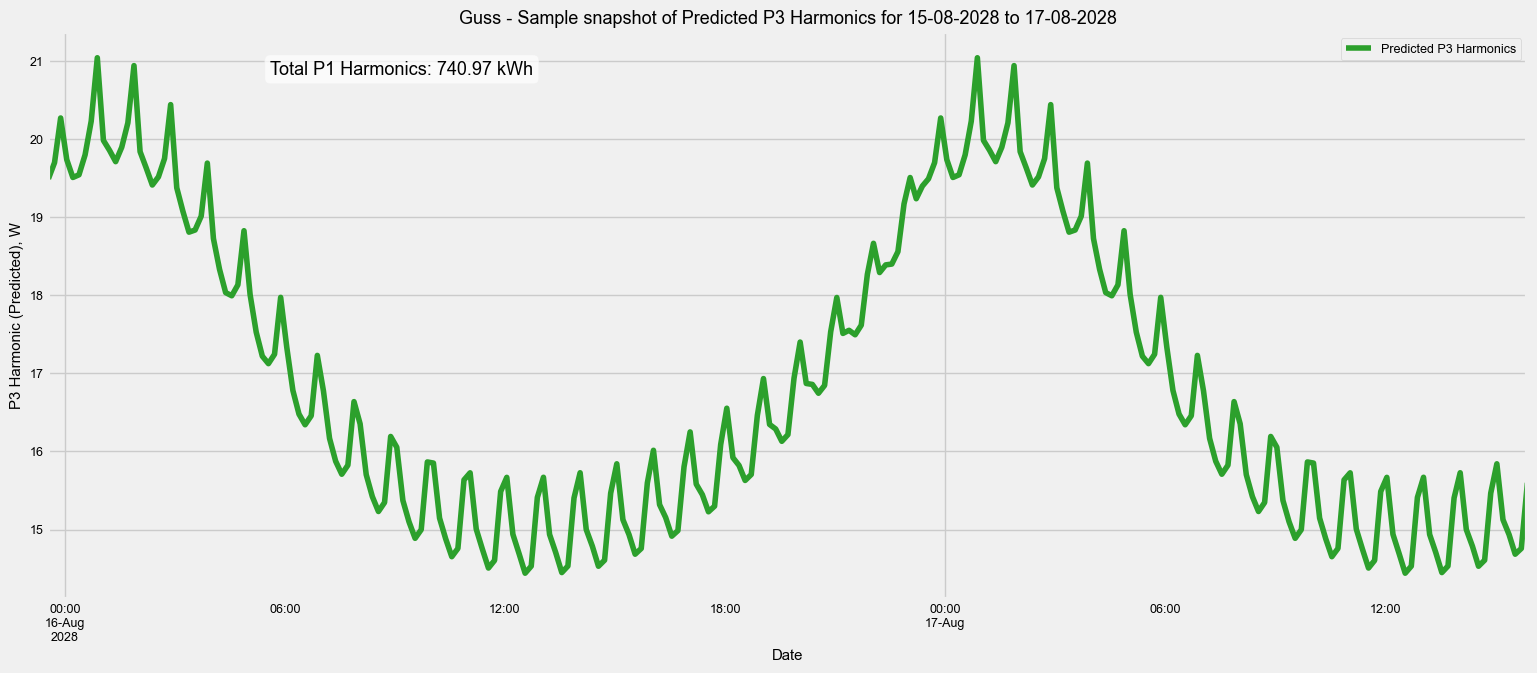

In [67]:
gp3_day = g_p3_future.loc['2028-08-15 23:33:00':'2028-08-17 15:53:00']

ax = gp3_day[['y_pred']].plot(
    figsize=(17,7), 
    label='Predicted P3 Harmonics', 
    color=color_pal[2], 
    title="Guss - Sample snapshot of Predicted P3 Harmonics for 15-08-2028 to 17-08-2028"
)

ax.set_xlabel('Datetime', rotation=0)

# Add text annotation at a specific point
ax.text(0.15, 0.95, f'Total P1 Harmonics: {g_p3_future_kWh:0.2f} kWh', transform=ax.transAxes, fontsize=13,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.73))

plt.xlabel('Date')
plt.ylabel('P3 Harmonic (Predicted), W')
plt.grid(True)
plt.legend(['Predicted P3 Harmonics'])

plt.savefig('gus_p3_predicted.jpg', dpi=307)
plt.show()

<br>

### Summary information

In [69]:
g_tot_harmonic_5y = g_p1_future_kWh + g_p2_future_kWh + g_p3_future_kWh
print(f"Total Harmonics for Guss in 5 years: {g_tot_harmonic_5y:.02f} kWh")

Total Harmonics for Guss in 5 years: 2448.86 kWh


### Cost in Money of Harmonics

In [70]:
#cost of electricity...
def energyCost(x: float, residential=True, tag='') -> float:
    """
    Arguments:
        x = Energy, kWh.
        residential
            True: Residential
            False: Non-Residential
            
        tag = ''
            slt-lv, slt-mv, slt-hv, slt-hv steel, slt-hv mines. 
            (special load tariff for non-residential customers)
        
    Returns:
        A tuple of
        (electricity_charge, lighting_levy, national_electrification_levy, service_charge, NHIL, VAT, total_charge)
    """
    
    total_charge = 0.0
    electricityCost = 0.0
    service_charge = 0.0
    lighting_levy = 0.0
    nat_elec_levy = 0.0
    VAT = 0.0; NHIL = 0.0;
    if(residential): #Residential Customer.
        
        if((x >= 0) and (x <= 30)): #lifeline customer...
            service_charge = 2.13
            electricityCost = (0.634792 * x) 
        else:
            service_charge = 10.730886
            if ((x > 30) and (x <= 300)):
                electricityCost = (0.634792 * 30) + (1.405722 * (x - 30))
            elif ((x > 300)):# and (x <= 600)):
                electricityCost = (0.634792 * 30) + (1.405722 * 270)  + (1.857432 * (x - 300))
            #elif (x > 600):
            #    electricityCost = (0.544627 * 30) + (1.157212 * 270)  + (1.501837 * 300) + (1.668708 * (x - 600))
        
        #calculating total energy cost.
        lighting_levy = 0.03 * electricityCost
        nat_elec_levy = 0.02 * electricityCost
        total_charge = electricityCost + lighting_levy + nat_elec_levy + service_charge
    
    else: #Nonresidential Customer.
        if (tag == ''):
            service_charge = 12.428245
            if ((x >= 0) and (x <= 300)):
                electricityCost = (1.269145 * x)
            elif ((x > 300)):# and (x <= 600)):
                electricityCost = (1.269145 * 300) + (1.577242 * (x - 300))
            #elif (x > 600):
            #    electricityCost = (1.088876 * 300) + (1.158681 * 300) + (1.729692 * (x - 600))
        else: #Special load tariffs.
            service_charge = 500.00
            if ('lv' in tag.lower()): 
                electricityCost = (x * 1.723461)
            elif ('mv' in tag.lower()):
                electricityCost = (x * 1.308541)
            elif ('steel' in tag.lower()):
                electricityCost = (x * 0.968627)
            elif (tag.lower() == 'mines'):
                electricityCost = (x * 3.430618)
            elif ('hv' in tag.lower()):
                electricityCost = (x * 1.373370)
            
        #other tariffs...
        lighting_levy = 0.03 * electricityCost
        nat_elec_levy = 0.02 * electricityCost
        pre_tax = lighting_levy + nat_elec_levy + service_charge + electricityCost
        NHIL = 0.05 * (pre_tax)
        VAT = 0.15 * (NHIL + pre_tax)
        total_charge = pre_tax + VAT + NHIL
                
    return total_charge

In [71]:
monthly_kWh = g_tot_harmonic_5y / (5*12)
total_GHS_5y = 5 * 12 * energyCost(monthly_kWh, residential=False)
print(f"For a 5 year sum of {g_tot_harmonic_5y:.02f} kWh ({monthly_kWh:.02f} kWh monthly), equivalent to GHS {total_GHS_5y:0.2f} over 5 years") 

For a 5 year sum of 2448.86 kWh (40.81 kWh monthly), equivalent to GHS 4840.93 over 5 years


<br><br><br>

## Smooth the Patterns to Reveal the Seasonality.

The graphs of the predictions into the future follows the seasonality observed in the actual data. The following snapshots reveals this information.

In [123]:
from scipy.signal import savgol_filter

### P1 using Savgol Filter

In [126]:
# Create a copy
g_p1_sv = g_p1.copy(deep = True)
g_p1_sv = g_p1_sv.drop(columns=['hour', 'minute'])

<Axes: xlabel='Datetime'>

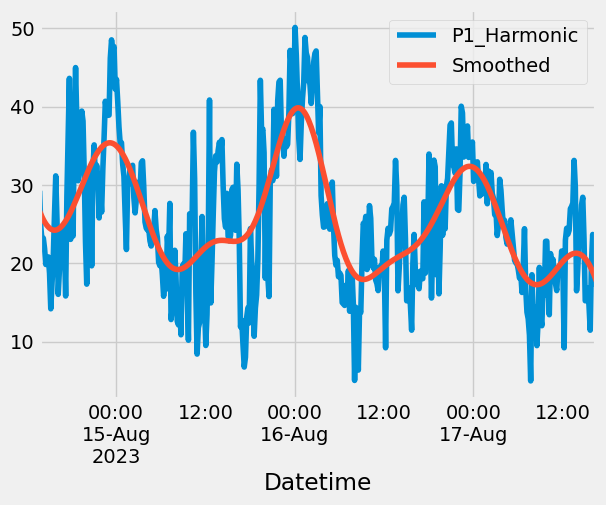

In [134]:
#Smoothening the data 3 times to see how it affects accuracy.
g_p1_sv['Smoothed'] = savgol_filter(g_p1_sv['P1_Harmonic'], window_length=7, polyorder=2)
for _ in range(1,30000):
    g_p1_sv['Smoothed'] = savgol_filter(g_p1_sv['Smoothed'], window_length=7, polyorder = 2)

g_p1_sv.plot()

<br><br>

### P2 using Savgol Filter

In [135]:
# Create a copy
g_p2_sv = g_p2.copy(deep = True)
g_p2_sv = g_p2_sv.drop(columns=['hour', 'minute'])

<Axes: xlabel='Datetime'>

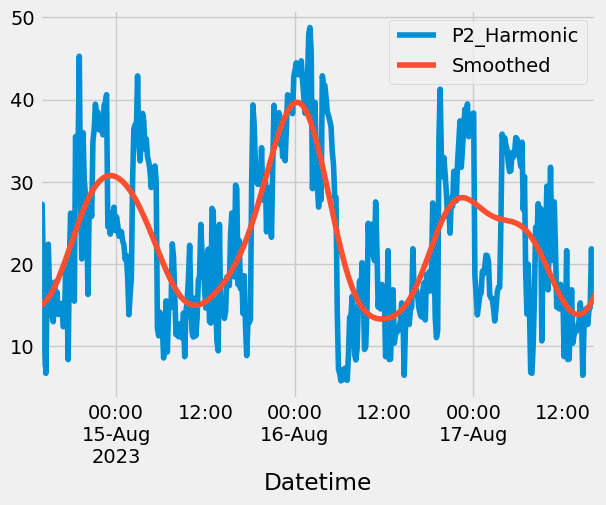

In [136]:
#Smoothening the data 3 times to see how it affects accuracy.
g_p2_sv['Smoothed'] = savgol_filter(g_p2_sv['P2_Harmonic'], window_length=7, polyorder=2)
for _ in range(1,30000):
    g_p2_sv['Smoothed'] = savgol_filter(g_p2_sv['Smoothed'], window_length=7, polyorder = 2)

g_p2_sv.plot()

<br><br>

### P3 using Savgol Filter

In [137]:
# Create a copy
g_p3_sv = g_p3.copy(deep = True)
g_p3_sv = g_p3_sv.drop(columns=['hour', 'minute'])

<Axes: xlabel='Datetime'>

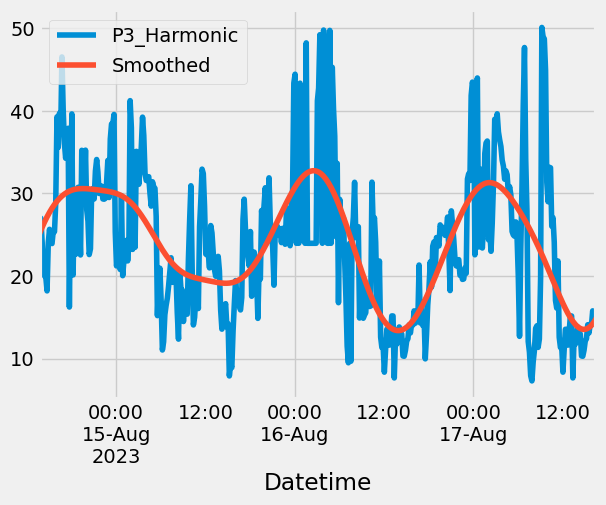

In [138]:
#Smoothening the data 3 times to see how it affects accuracy.
g_p3_sv['Smoothed'] = savgol_filter(g_p3_sv['P3_Harmonic'], window_length=7, polyorder=2)
for _ in range(1,30000):
    g_p3_sv['Smoothed'] = savgol_filter(g_p3_sv['Smoothed'], window_length=7, polyorder = 2)

g_p3_sv.plot()